# **Feature Extraction**

1) Store the sequences of lncRNA in a dictionary fetched using NCBI

In [ ]:
def read_fasta_file(filename):
    sequences = {}
    with open(filename, 'r') as fasta_file:
        lines = fasta_file.readlines()
        current_id = None
        current_sequence = ''
        for line in lines:
            line = line.strip()
            if line.startswith('>'):
                if current_id is not None:
                    sequences[current_id] = current_sequence
                st=line.find('>') + 1
                end=line.find(':',st)
                current_id=line[st:end]
                current_sequence = ''
            else:
                current_sequence += line
        if current_id is not None:
            sequences[current_id] = current_sequence
    return sequences

# Example usage
filename = 'lncRNA_new.out'  # Replace with your .fa file path
sequences = read_fasta_file(filename)



In [ ]:
lncRNA_names=(list(sequences.keys()))
print(len(lncRNA_names))

In [ ]:
import pickle

with open("./dataset/processed/kmer_frequencies.pickle", 'rb') as file:
    kmer_frequencies=pickle.load(file)

with open("./dataset/processed/kmer_similarity_matrix.pickle", 'rb') as file:
    kmer_similarity_matrix=pickle.load(file)

with open("./dataset/processed/lncRNA_names.pickle", 'rb') as file:
    lncRNA_names=pickle.load(file)

with open("./dataset/processed/sequences.pickle", 'rb') as file:
    sequences=pickle.load(file)

with open("./dataset/processed/levdis_feature_matrix.pickle", 'rb') as file:
    levdis_feature_matrix=pickle.load(file)


with open("./dataset/processed/lnc_target_similarity_matrix.pickle", 'rb') as file:
    lnc_target_similarity_matrix=pickle.load(file)




Finding Kmer similarity matrix from LncRNA sequence information

In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean
import itertools
k = 3
possible_kmers = [''.join(p) for p in itertools.product('ATCGatcg', repeat=k)]

# Create a dictionary to store the k-mer frequencies for each lncRNA ID
kmer_frequencies = {}
lncRNAseq=sequences
# Iterate over the lncRNA sequences
for lncRNA_id, sequence in lncRNAseq.items():
    # Initialize a dictionary to store the k-mer frequencies for the current sequence
    sequence_kmers = {kmer: 0 for kmer in possible_kmers}

    # Iterate over the sequence with a sliding window of size k
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        sequence_kmers[kmer] += 1

    # Store the k-mer frequencies for the current lncRNA ID
    kmer_frequencies[lncRNA_id] = sequence_kmers

similarity_matrix = np.zeros((len(lncRNAseq), len(lncRNAseq)))
for i, (lncRNA_id1, sequence_kmers1) in enumerate(kmer_frequencies.items()):
    for j, (lncRNA_id2, sequence_kmers2) in enumerate(kmer_frequencies.items()):
        distance = euclidean(list(sequence_kmers1.values()), list(sequence_kmers2.values()))
        similarity = 1 / (1 + distance)
        similarity_matrix[i, j] = similarity
print(similarity_matrix)

[[1.         0.0111118  0.03837309 ... 0.03672453 0.00845439 0.03189998]
 [0.0111118  1.         0.00955184 ... 0.00946163 0.0133034  0.01284191]
 [0.03837309 0.00955184 1.         ... 0.0606357  0.00746898 0.02687613]
 ...
 [0.03672453 0.00946163 0.0606357  ... 1.         0.00744142 0.02663992]
 [0.00845439 0.0133034  0.00746898 ... 0.00744142 1.         0.00946078]
 [0.03189998 0.01284191 0.02687613 ... 0.02663992 0.00946078 1.        ]]


Heatmap for kmer similarity matrix


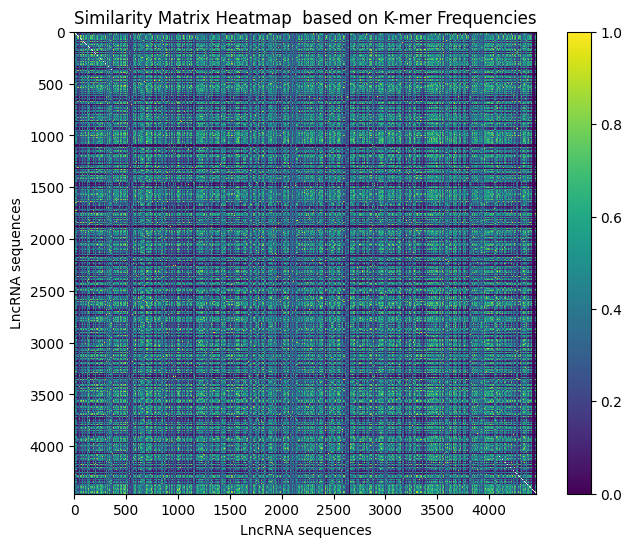

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming similarity_matrix contains your 4458x4458 similarity matrix
# Create a copy of the similarity matrix
similarity_matrix_copy = np.copy(kmer_similarity_matrix)

# Set diagonal elements to NaN
np.fill_diagonal(similarity_matrix_copy, np.nan)

# Normalize the similarity matrix between 0 and 1, ignoring NaN values
scaler = MinMaxScaler()
normalized_similarity_matrix = scaler.fit_transform(similarity_matrix_copy)

plt.figure(figsize=(8, 6))
plt.imshow(normalized_similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Similarity Matrix Heatmap  based on K-mer Frequencies')
plt.xlabel('LncRNA sequences')
plt.ylabel('LncRNA sequences')
plt.show()


<ipython-input-4-9c58d5b5a1e6>:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap='viridis', s=5)


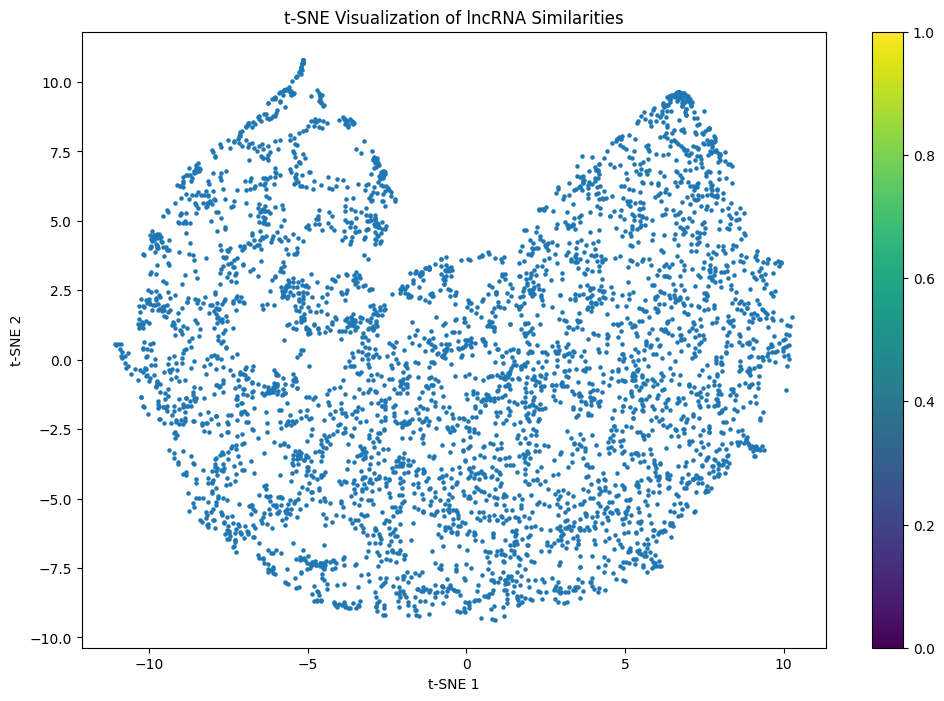

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming kmer_similarity_matrix is your similarity matrix
similarity_matrix = np.copy(kmer_similarity_matrix)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(similarity_matrix)

# Plot t-SNE results
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap='viridis', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of lncRNA Similarities')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


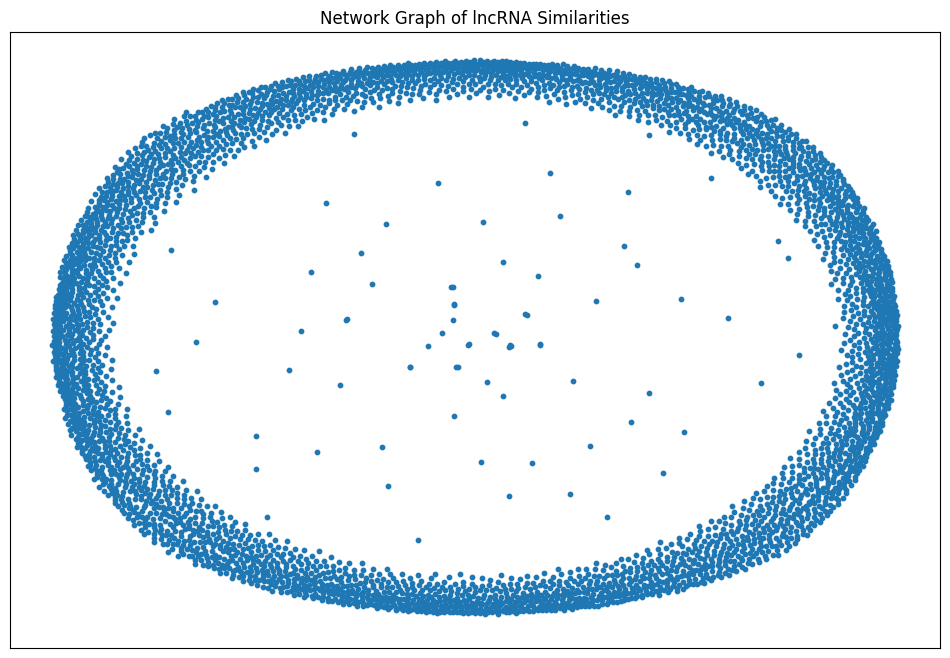

In [ ]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add nodes
num_nodes = similarity_matrix.shape[0]
G.add_nodes_from(range(num_nodes))

# Add edges with a similarity threshold (e.g., 0.7)
threshold = 0.7
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

# Plot network graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=10)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Network Graph of lncRNA Similarities')
plt.show()


Finding levenshtein distance as a feature

In [ ]:
import numpy as np
!pip install Levenshtein

import Levenshtein
lncRNAseq=sequences
feature_matrix = np.zeros((len(lncRNAseq), len(lncRNAseq)))

for i, (lncRNA_id1, sequence1) in enumerate(lncRNAseq.items()):
    for j, (lncRNA_id2, sequence2) in enumerate(lncRNAseq.items()):
        # Calculate the Levenshtein distance between the sequences
        distance = Levenshtein.distance(sequence1, sequence2)
        similarity = 1 / (1 + distance)
        # Store the distance in the feature matrix
        feature_matrix[i, j] = similarity
        # disfeature_matrix[i, j] = distance

# Print the feature matrix
print(feature_matrix)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.3 MB/s eta 0:00:00
[[1.         0.00166667 0.00704225 ... 0.00671141 0.00126582 0.00591716]
 [0.00166667 1.         0.00136799 ... 0.00135685 0.00193424 0.00189753]
 [0.00704225 0.00136799 1.         ... 0.02325581 0.00108225 0.00425532]
 ...
 [0.00671141 0.00135685 0.02325581 ... 1.         0.00107527 0.00414938]
 [0.00126582 0.00193424 0.00108225 ... 0.00107527 1.         0.0014245 ]
 [0.00591716 0.00189753 0.00425532 ... 0.00414938 0.0014245  1.        ]]


In [ ]:
import pickle
with open("levdis_feature_matrix.pickle", 'wb') as file:
    pickle.dump(feature_matrix, file)

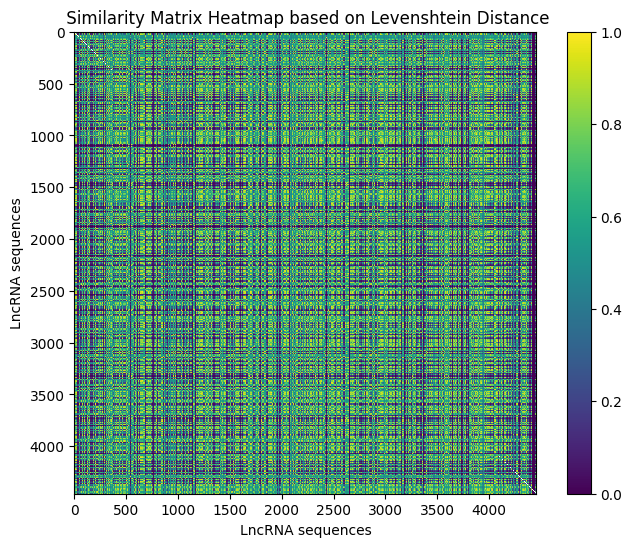

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming similarity_matrix contains your 4458x4458 similarity matrix
# Create a copy of the similarity matrix
similarity_matrix_copy = np.copy(feature_matrix)

# Set diagonal elements to NaN
np.fill_diagonal(similarity_matrix_copy, np.nan)

# Normalize the similarity matrix between 0 and 1, ignoring NaN values
scaler = MinMaxScaler()
normalized_similarity_matrix = scaler.fit_transform(similarity_matrix_copy)

plt.figure(figsize=(8, 6))
plt.imshow(normalized_similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(' Similarity Matrix Heatmap based on Levenshtein Distance')
plt.xlabel('LncRNA sequences')
plt.ylabel('LncRNA sequences')
plt.show()


Finding lncRNA target association

In [ ]:
import pandas as pd

lncRNAdic=sequences
# Use the retrieved dictionary
names=[]
# names=lncRNAdic.keys()
for i in lncRNAdic.keys():
  names.append(i)

# # Read the Excel file
data_frame = pd.read_excel('experimental lncRNA-disease information.xlsx')
dis = data_frame['Disease Name'].tolist()
lncname = data_frame['ncRNA Symbol'].tolist()
nid= data_frame['NONCODE'].tolist()
name=[]

print(len(lncname))
print(len(names))

name=list(set(names))
print(len(name))

data_frame = pd.read_excel('output.xlsx')
lncRNAs = data_frame['ncName'].tolist()
genes = data_frame['tarID'].tolist()
genes_name = data_frame['tarName'].tolist()
gene_type=data_frame['tarType']
useful_gene_type=[]
print(len(lncRNAs))
# # print(lncRNAs)
useful_lncRNAs=[]
useful_genes=[]
genes1=[]
for i in range(len(lncRNAs)):
    if lncRNAs[i] in name:
        useful_lncRNAs.append(lncRNAs[i])
        useful_genes.append(genes[i])
        useful_gene_type.append(gene_type[i])
        genes1.append(genes_name[i])


print(len(useful_genes))

lncRNA_unique = list(set(useful_lncRNAs))
genes_unique = list(set(useful_genes))
print(len(lncRNA_unique))
print(len(genes_unique))


208275
4458
4458
658171
46563
1430
4870


In [ ]:


# # Create an empty matrix
import numpy as np
matrix = np.zeros((len(name), len(genes_unique)), dtype=int)


for i in range(len(useful_lncRNAs)):
    if useful_genes[i]!='-':
      lnc_idx=name.index(useful_lncRNAs[i])
      gene_idx=genes_unique.index(useful_genes[i])
      matrix[lnc_idx,gene_idx]=1



import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def create_similarity_matrix(association_matrix):
    # Calculate cosine similarity between lncRNAs
    similarity_matrix = cosine_similarity(association_matrix)


    return similarity_matrix

f3 = create_similarity_matrix(matrix)

In [ ]:

lncRNA_unique = list(set(useful_lncRNAs))
genes_unique = list(set(total_genes))
print(len(lncRNA_unique))
print(len(genes_unique))

# # Create an empty matrix
import numpy as np
matrix1 = np.zeros((len(name), len(total_genes)), dtype=int)


for i in range(len(useful_lncRNAs)):
    if genes1[i]!='-':
      lnc_idx=name.index(useful_lncRNAs[i])
      gene_idx=total_genes.index(genes1[i])
      matrix1[lnc_idx,gene_idx]=1


1430
13356


In [ ]:
matrix1.shape

(4458, 13356)

Proportion of biomolecules as targets in lncRNA-gene association

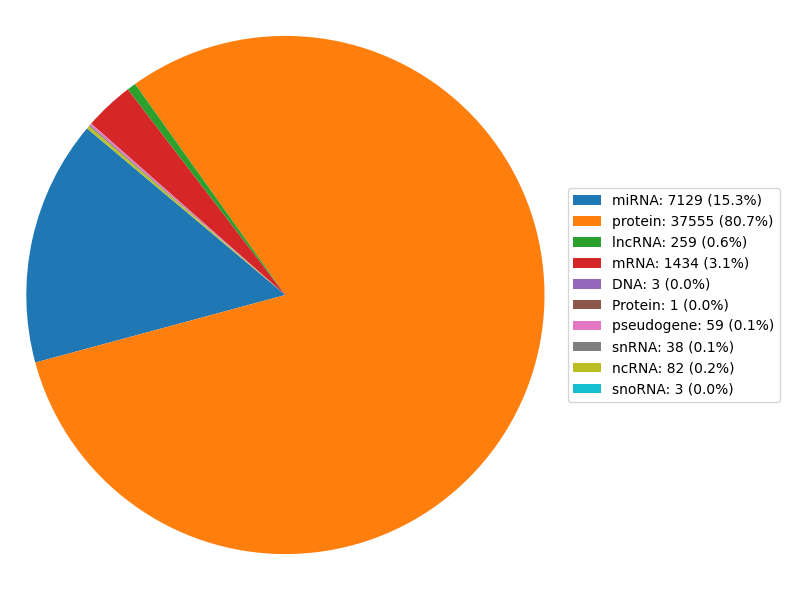

In [ ]:

import matplotlib.pyplot as plt
from collections import Counter

data = useful_gene_type

# Count occurrences of each unique label
label_counts = Counter(data)
labels = list(label_counts.keys())
sizes = list(label_counts.values())

# Create pie chart
plt.figure(figsize=(8, 6))
patches, texts, autotexts = plt.pie(sizes,  startangle=140, autopct=' ')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Plot colored boxes with label names and percentages sideways
colors = [patch.get_facecolor() for patch in patches]
legend_labels = [f'{label}: {sizes[i]} ({sizes[i] / len(data) * 100:.1f}%)' for i, label in enumerate(labels)]

plt.legend(handles=patches, labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()

In [ ]:
with open("lnc_target_matrix.pickle", 'wb') as file:
    pickle.dump(matrix, file)

with open("lnc_target_similarity_matrix.pickle", 'wb') as file:
    pickle.dump(f3, file)

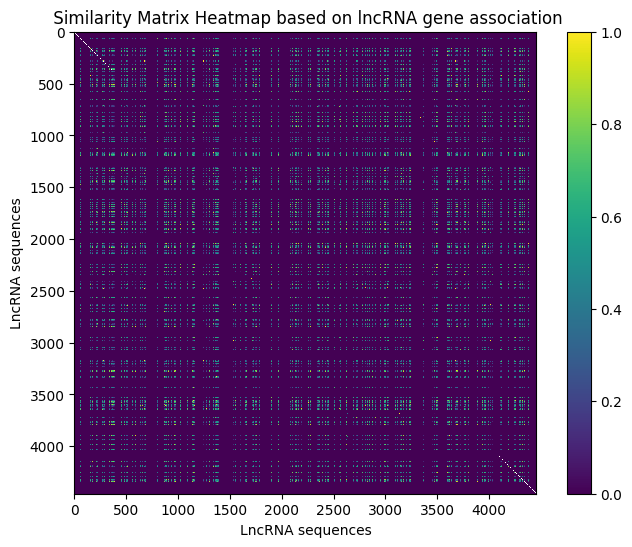

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming similarity_matrix contains your 4458x4458 similarity matrix
# Create a copy of the similarity matrix
similarity_matrix_copy = np.copy(lnc_target_similarity_matrix)

# Set diagonal elements to NaN
np.fill_diagonal(similarity_matrix_copy, np.nan)

# Normalize the similarity matrix between 0 and 1, ignoring NaN values
scaler = MinMaxScaler()
normalized_similarity_matrix = scaler.fit_transform(similarity_matrix_copy)

plt.figure(figsize=(8, 6))
plt.imshow(normalized_similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(' Similarity Matrix Heatmap based on lncRNA gene association')
plt.xlabel('LncRNA sequences')
plt.ylabel('LncRNA sequences')
plt.show()


Select the corresponding diseases for which I have lncRNA sequence available

In [ ]:
import pandas as pd


# # # Read the Excel file
data_frame = pd.read_excel('experimental lncRNA-disease information.xlsx')
# name=[]
dis = data_frame['Disease Name'].tolist()
lnc = data_frame['ncRNA Symbol'].tolist()
final_dis=[]
for l in range(len(lnc)):
  if lnc[l] in lncRNA_names and lnc[l]!=float and dis[l]!=float:
    final_dis.append(dis[l])

In [ ]:
disease_names=list(set(final_dis))
print(len(disease_names))

498


In [ ]:
disease_names=list(set(set(map(str.lower, disease_names))))

Extracting DOID of selected diseases

In [ ]:
print(len(list(set(lncRNA_names))))

import requests
import pickle


base_url = "https://www.ebi.ac.uk/ols/api"

# disease_names = ["colorectal cancer", "diabetes", "hypertension"]  # Replace with your list of disease names
not_found=[]
count=0
doids=[]
doid_dic={}
new_dis=[]
for disease_name in disease_names:
    search_url = f"{base_url}/search?q={disease_name}&ontology=doid"

    response = requests.get(search_url)
    data = response.json()
    count+=1
    if count%100==0:
      print(count)
    if 'response' in data and 'docs' in data['response']:
        docs = data['response']['docs']
        try:
            if docs:
                doid = docs[0]['obo_id']
                term_label = docs[0]['label']
                doids.append(doid)
                new_dis.append(disease_name)
                doid_dic[disease_name]=doid
                # print(f"Disease Name: {disease_name}")
                # print(f"DOID: {doid}")
                # print(f"Term Label: {term_label}")
            else:
                # print(f"No results found for: {disease_name}")
                not_found.append(disease_name)
        except:
                not_found.append(disease_name)

    else:
        print(f"Error retrieving data for: {disease_name}")


print(len(disease_names))
print(len(not_found))
print(doids)

4458
100
200
300
400
470
2
['DOID:437', 'DOID:399', 'DOID:8986', 'DOID:12236', 'DOID:9663', 'DOID:10223', 'DOID:0050922', 'DOID:9256', 'DOID:14681', 'DOID:0060199', 'DOID:3910', 'DOID:0050865', 'DOID:4001', 'DOID:9296', 'DOID:0050850', 'DOID:8618', 'DOID:114', 'DOID:5517', 'DOID:11830', 'DOID:5419', 'DOID:4362', 'DOID:0060317', 'DOID:3908', 'DOID:1397', 'DOID:1679', 'DOID:0060240', 'DOID:6255', 'DOID:594', 'DOID:3021', 'DOID:5426', 'DOID:12583', 'DOID:0111526', 'DOID:162', 'DOID:5746', 'DOID:0111719', 'DOID:0080522', 'DOID:13743', 'DOID:12894', 'DOID:2377', 'DOID:0070310', 'DOID:7575', 'DOID:5603', 'DOID:0060058', 'DOID:0111373', 'DOID:10652', 'DOID:1749', 'DOID:57', 'DOID:10534', 'DOID:2025', 'SYMP:0000199', 'DOID:3302', 'DOID:10187', 'DOID:3627', 'DOID:3213', 'DOID:10657', 'DOID:0040088', 'DOID:14250', 'DOID:1324', 'DOID:4467', 'DOID:1583', 'DOID:3498', 'DOID:13189', 'DOID:0080600', 'DOID:3068', 'DOID:5274', 'DOID:0060106', 'DOID:5041', 'DOID:3071', 'DOID:0080546', 'DOID:0090020', 'D

In [ ]:
doids=list(doid_dic.values())
disease_names=list(doid_dic.keys())

with open("doids.pickle", 'wb') as file:
    pickle.dump(doids, file)

with open("doid_dic.pickle", 'wb') as file:
    pickle.dump(doid_dic, file)



In [ ]:
import pickle
with open("doid_dic.pickle", 'rb') as file:
    doid_dic=pickle.load(file)


In [ ]:
doids=list(doid_dic.values())
disease_names=list(doid_dic.keys())

In [ ]:
print(len(doids))

468


In [ ]:
import xml.etree.ElementTree as ET

# Your XML string (with potential leading characters)

def find_mesh_term(xml_string):
  xml_declaration_index = xml_string.find('<?xml')

  # Extract the substring starting from the XML declaration
  xml_cleaned = xml_string[xml_declaration_index:]

  # Parse the cleaned XML string
  root = ET.fromstring(xml_cleaned)

  # Find the TranslationSet section
  translation_set = root.find('TranslationSet')

  # Extract Mesh terms
  mesh_terms = [translation.find('To').text for translation in translation_set.findall('Translation')]

  # Print extracted Mesh terms
  mesh=""
  f=0
  # print(mesh_terms[0])
  for s in mesh_terms[0]:
    # print(s)
    if s=='"' and f==1:
      break
    if s=='"':
      f=1
    if s!='"':
      mesh+=s

  return mesh


import requests
count=0
new_dis_name=[]
new_doid_dic={}
for disease in disease_names:
    try:
      count+=1
      if count%100==0:
        print(count)
      url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=mesh&term={disease}"

      response = requests.get(url)

      if response.status_code == 200:
          new_dis=find_mesh_term(response.text)
          new_dis_name.append(new_dis)
          new_doid_dic[new_dis]=doid_dic[disease]
      else:
          print("Failed to retrieve MeSH terms.")
    except:
        print(disease)
        new_dis_name.append(disease)

100
200
hypoxic-ischemic
300
400


In [ ]:
with open("doids.pickle", 'wb') as file:
    pickle.dump(doids, file)

Creating disease gene association matrix

In [ ]:
import pandas as pd

# Replace 'your_file.tsv' with the actual path to your TSV file
tsv_file_path = 'human_disease_textmining_filtered.tsv'

# Load the TSV file into a Pandas DataFrame
df = pd.read_csv(tsv_file_path, sep='\t')

# Now you can work with the 'df' DataFrame containing the data from the TSV file
diseases=list(df.iloc[:,3])

In [ ]:
genes=list(df.iloc[:,1])

print(len(set(genes)))

20415


In [ ]:
import pandas as pd
data_frame = pd.read_excel('output.xlsx')
genes1 = data_frame['tarName'].tolist()
genes1 = list(set(genes1))
tsv_file_path = 'human_disease_textmining_filtered.tsv'

# Load the TSV file into a Pandas DataFrame
df = pd.read_csv(tsv_file_path, sep='\t')
genes2=list(set(df.iloc[:,1]))
count=0
for i in genes1:
    if i in genes2:
      count+=1

print(count)



7225


In [ ]:
genes1=list(set(genes1))

In [ ]:
count=0
for i in genes1:
    if i in genes2:
      count+=1

print(count)


2106


In [ ]:
total_genes=list(set(genes1+genes2))
len(total_genes)

13356

In [ ]:

import pandas as pd

# Replace 'your_file.tsv' with the actual path to your TSV file
tsv_file_path = 'human_disease_textmining_filtered.tsv'

# Load the TSV file into a Pandas DataFrame
df = pd.read_csv(tsv_file_path, sep='\t')

# Now you can work with the 'df' DataFrame containing the data from the TSV file
diseases=list(df.iloc[:,3])
genes=list(df.iloc[:,1])
doid=list(df.iloc[:,2])
dis=disease_names
d=[]
count=0
c=0
gdi_new={}
for i in dis:
    x=i.split(" ")

    for j in range(len(diseases)):
        c=0
        for k in x:
            if k in diseases[j]:
                c+=1
        if c==len(diseases[j]) or c>=2:
            if i not in gdi_new:
                d.append(doid[j])
                gdi_new[i]=[genes[j]]
            else:
                gdi_new[i].append(genes[j])
    # if i in dis:
    #     count+=1
print(len(dis))
print(len(gdi_new))
# print(gdi_new)
print(len(d))
print(d)


468
141
141
['DOID:0070276', 'DOID:332', 'DOID:4471', 'DOID:0111249', 'DOID:8618', 'DOID:3716', 'DOID:0060861', 'DOID:6255', 'DOID:5426', 'DOID:5746', 'DOID:1089', 'DOID:2378', 'DOID:0112290', 'DOID:0080649', 'DOID:4471', 'DOID:0050644', 'DOID:14004', 'DOID:4471', 'DOID:0080374', 'DOID:0080208', 'DOID:0090020', 'DOID:10823', 'DOID:14004', 'DOID:4226', 'DOID:0111506', 'DOID:0111511', 'DOID:1540', 'DOID:11934', 'DOID:11612', 'DOID:7596', 'DOID:0040092', 'DOID:5683', 'DOID:3525', 'DOID:749', 'DOID:526', 'DOID:0050425', 'DOID:0112247', 'DOID:0080208', 'DOID:11394', 'DOID:0050958', 'DOID:1289', 'DOID:0080208', 'DOID:4471', 'DOID:9253', 'DOID:4471', 'DOID:4439', 'DOID:0050156', 'DOID:0050156', 'DOID:0050650', 'DOID:0080638', 'DOID:0050958', 'DOID:3500', 'DOID:4471', 'DOID:9352', 'DOID:3393', 'DOID:9408', 'DOID:4471', 'DOID:0060041', 'DOID:9352', 'DOID:1040', 'DOID:0070322', 'DOID:4471', 'DOID:0050939', 'DOID:6255', 'DOID:0050881', 'DOID:0112247', 'DOID:4471', 'DOID:4471', 'DOID:0080827', 'DO

In [ ]:
# with open("adjacencyList_of_Diseases&Genes.pickle", "rb") as file:
#     adj = pickle.load(file)

import numpy as np
adj=gdi_new
genes = set()
for gene_list in adj.values():
    genes.update(gene_list)
genes = sorted(list(genes))

print(len(genes))
# Create an empty adjacency matrix filled with zeros
num_diseases = len(disease_names)
num_genes = len(genes)
gdi = np.zeros(((num_diseases), (num_genes)), dtype=int)


for d in range(len(disease_names)):
  if disease_names[d] in adj:
    for i,g in enumerate(genes):
      if g in adj[disease_names[d]]:
        gdi[d][i]=1


10432


In [ ]:

genes2=genes

Creating gene-gene association matrix

In [ ]:
num_diseases = len(disease_names)
num_genes = len(total_genes)
matrix2 = np.zeros(((num_diseases), (num_genes)), dtype=int)


for d in range(len(disease_names)):
  if disease_names[d] in adj:
    for i,g in enumerate(total_genes):
      if g in adj[disease_names[d]]:
        matrix2[d][i]=1

In [ ]:
genes_matrix=np.vstack((matrix1,matrix2)).T
genes_matrix.shape

(13356, 4926)

In [ ]:
import pickle
with open("genes_matrix.pickle", 'wb') as file:
    pickle.dump(genes_matrix, file)

In [ ]:
import pickle
with open("genes_matrix.pickle", 'rb') as file:
    genes_matrix=pickle.load(file)


In [ ]:
(genes_matrix.shape)

(13356, 4926)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
genes_func_sim = cosine_similarity(genes_matrix)

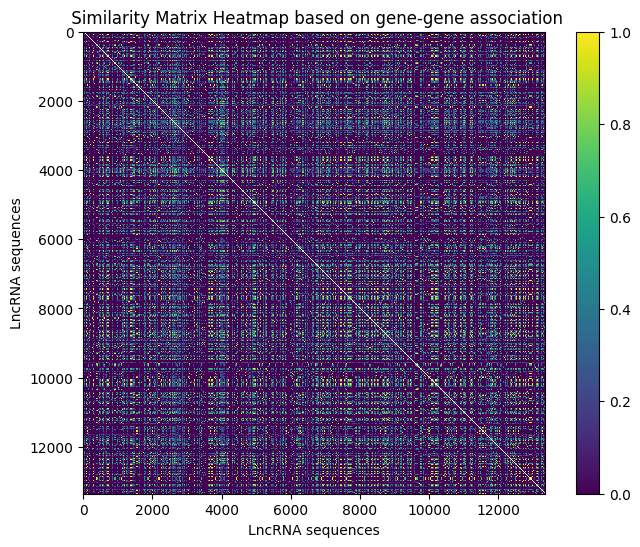

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming similarity_matrix contains your 4458x4458 similarity matrix
# Create a copy of the similarity matrix
similarity_matrix_copy = np.copy(genes_func_sim)

# Set diagonal elements to NaN
np.fill_diagonal(similarity_matrix_copy, np.nan)

# Normalize the similarity matrix between 0 and 1, ignoring NaN values
scaler = MinMaxScaler()
normalized_similarity_matrix = scaler.fit_transform(similarity_matrix_copy)

plt.figure(figsize=(8, 6))
plt.imshow(normalized_similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(' Similarity Matrix Heatmap based on gene-gene association')
plt.xlabel('LncRNA sequences')
plt.ylabel('LncRNA sequences')
plt.show()


Extracting Gaussian Interaction profiles using lncRNA disease association

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def gaussian_kernel_similarity_matrix(matrix, sigma):
    """
    Compute the Gaussian (RBF) kernel similarity matrix for a given matrix.

    Args:
    matrix (np.ndarray): A 2D numpy array of shape (n, m).
    sigma (float): The width parameter for the Gaussian kernel.

    Returns:
    np.ndarray: A 2D numpy array of shape (n, n) representing the Gaussian kernel similarity matrix.
    """
    # Compute the pairwise squared Euclidean distances
    pairwise_sq_dists = squareform(pdist(matrix, 'sqeuclidean'))

    # Compute the Gaussian (RBF) kernel similarity matrix
    kernel_matrix = np.exp(-pairwise_sq_dists / (2 * sigma**2))

    return kernel_matrix

genes_gaussian_sim = gaussian_kernel_similarity_matrix(genes_matrix,1)


In [ ]:
import pickle
with open("genes_func_sim.pickle", 'wb') as file:
    pickle.dump(genes_func_sim, file)


with open("genes_gaussian_sim.pickle", 'wb') as file:
    pickle.dump(genes_gaussian_sim, file)


In [ ]:
with open("genes_names_relatedToDisease.pickle", 'wb') as file:
    pickle.dump(genes, file)

In [ ]:
count=0
for i in gdi:
  for j in i:
    if j==1:
      count+=1

print(count)

49095


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def create_similarity_matrix(association_matrix):
    # Calculate cosine similarity between lncRNAs2759502
    similarity_matrix = cosine_similarity(association_matrix)
    return similarity_matrix
gdi_num=create_similarity_matrix(gdi)

In [ ]:
import pickle
with open("disease_genes_association.pickle", 'rb') as file:
    gdi=pickle.load(file)
with open("genes_names_relatedToDisease.pickle", 'rb') as file:
    genes=pickle.load(file)


In [ ]:
with open("similarity_df.pickle", 'wb') as file:
    pickle.dump(kegg_data, file)

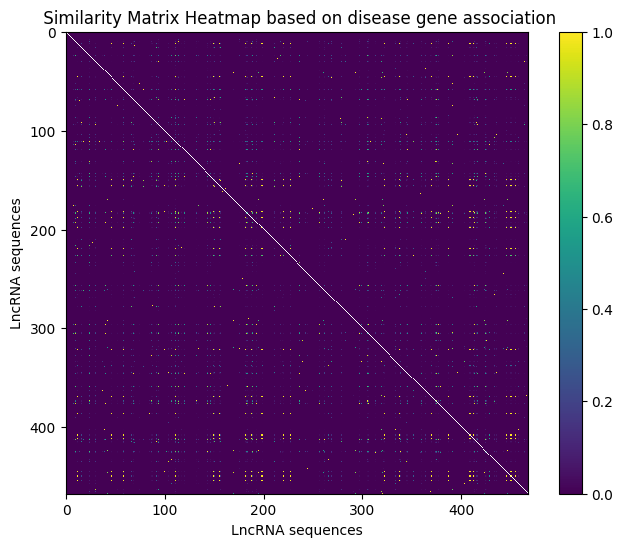

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming similarity_matrix contains your 4458x4458 similarity matrix
# Create a copy of the similarity matrix
similarity_matrix_copy = np.copy(gdi_num)

# Set diagonal elements to NaN
np.fill_diagonal(similarity_matrix_copy, np.nan)

# Normalize the similarity matrix between 0 and 1, ignoring NaN values
scaler = MinMaxScaler()
normalized_similarity_matrix = scaler.fit_transform(similarity_matrix_copy)

plt.figure(figsize=(8, 6))
plt.imshow(normalized_similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(' Similarity Matrix Heatmap based on disease gene association')
plt.xlabel('LncRNA sequences')
plt.ylabel('LncRNA sequences')
plt.show()


ENTRY       H00042                      Disease
NAME        Glioma
  SUPERGRP  Solid tumor [DS:H02421]
DESCRIPTION Gliomas are the most common of the primary brain tumors and account for more than 40% of all central nervous system neoplasms. Gliomas include tumours that are composed predominantly of astrocytes (astrocytomas), oligodendrocytes (oligodendrogliomas), mixtures of various glial cells (for example,oligoastrocytomas) and ependymal cells (ependymomas). The most malignant form of infiltrating astrocytoma - glioblastoma multiforme (GBM) - is one of the most aggressive human cancers. GBM may develop de novo (primary glioblastoma) or by progression from low-grade or anaplastic astrocytoma (secondary glioblastoma). Primary glioblastomas develop in older patients and typically show genetic alterations (EGFR amplification, p16/INK4a deletion, and PTEN mutations) at frequencies of 24-34%. Secondary glioblastomas develop in younger patients and frequently show overexpression of PDGF an

In [ ]:
doids[0]

'DOID:437'

Using the doSim function of R, I have disease semantic similarity for the given diseases

In [ ]:
import pandas as pd
ddsim=pd.read_csv("ddsim_target.csv")
dss = ddsim.values
print(dss.shape)


(468, 468)


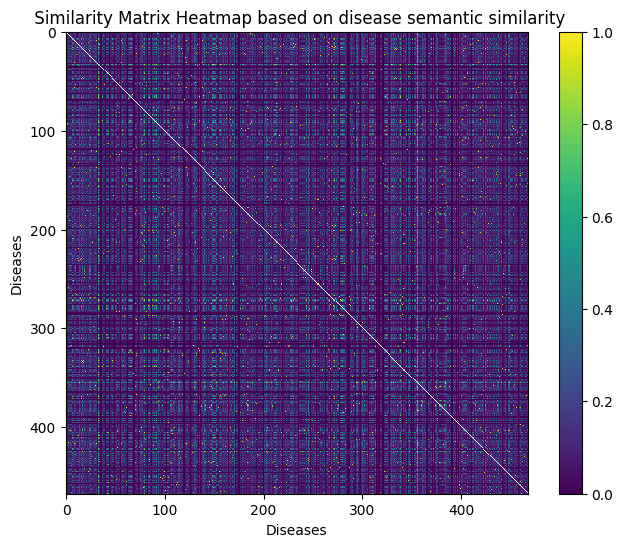

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming similarity_matrix contains your 4458x4458 similarity matrix
# Create a copy of the similarity matrix
similarity_matrix_copy = np.copy(dss)

# Set diagonal elements to NaN
np.fill_diagonal(similarity_matrix_copy, np.nan)

# Normalize the similarity matrix between 0 and 1, ignoring NaN values
scaler = MinMaxScaler()
normalized_similarity_matrix = scaler.fit_transform(similarity_matrix_copy)

plt.figure(figsize=(8, 6))
plt.imshow(normalized_similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(' Similarity Matrix Heatmap based on disease semantic similarity')
plt.xlabel('Diseases')
plt.ylabel('Diseases')
plt.show()


In [ ]:
with open("gip_dis.pickle", 'wb') as file:
    pickle.dump(gip_dis, file)

In [ ]:
import pickle
with open("kmer_similarity_matrix.pickle", 'rb') as file:
    kmer_similarity_matrix=pickle.load(file)

with open("levdis_feature_matrix.pickle", 'rb') as file:
    levdis_feature_matrix=pickle.load(file)

with open("lnc_target_similarity_matrix.pickle", 'rb') as file:
    lnc_target_similarity_matrix=pickle.load(file)

with open("disease_genes_sim_matrix.pickle", 'rb') as file:
    disease_genes_sim_matrix=pickle.load(file)

with open("dss.pickle", 'rb') as file:
    dss=pickle.load(file)

with open("lda.pickle", 'rb') as file:
    lda=pickle.load(file)

with open("gip_lnc.pickle", 'rb') as file:
    gip_lnc=pickle.load(file)

with open("gip_dis.pickle", 'rb') as file:
    gip_dis=pickle.load(file)

print(kmer_similarity_matrix.shape)
print(levdis_feature_matrix.shape)
print(lnc_target_similarity_matrix.shape)
print(disease_genes_sim_matrix.shape)
print(dss.shape)
print(lda.shape)
print(gip_lnc.shape)
print(gip_dis.shape)


(4458, 4458)
(4458, 4458)
(4458, 4458)
(468, 468)
(468, 468)
(4458, 468)
(4458, 4458)
(468, 468)


In [ ]:
import numpy as np
lncRNA_feature=np.hstack((kmer_similarity_matrix,levdis_feature_matrix,lnc_target_similarity_matrix))
disease_feature=np.hstack((disease_genes_sim_matrix,dss))

print(lncRNA_feature.shape)
print(disease_feature.shape)

(4458, 13374)
(468, 936)


In [ ]:
with open("lncRNA_names.pickle", 'rb') as file:
    lncRNA_names=pickle.load(file)
print(len(lncRNA_names))
print(len(disease_names))

4458
468


In [ ]:
import pandas as pd


# # # Read the Excel file
data_frame = pd.read_excel('experimental lncRNA-disease information.xlsx')
# name=[]
dis = data_frame['Disease Name'].tolist()
lnc = data_frame['ncRNA Symbol'].tolist()

print(len(dis))

208275


In [ ]:
print(len(lnc))
lnc=list(set(lnc))
print(len(set(dis)))

208275
641


In [ ]:
import pandas as pd


# # # Read the Excel file
data_frame = pd.read_excel('lncRNA2cancer.xlsx')
# name=[]
# dis = data_frame['cancer type'].tolist()
new_lnc = data_frame['name'].tolist()
count=0
for i in set(new_lnc):
  if i not in lnc:
    count+=1
print(count)

1556


Create lncRNA disease association matrix using the experimental lncRNA-disease information dataset


In [ ]:
import pandas as pd


# # # Read the Excel file
data_frame = pd.read_excel('experimental lncRNA-disease information.xlsx')
# name=[]
dis = data_frame['Disease Name'].tolist()
lnc = data_frame['ncRNA Symbol'].tolist()
count=0
lda = np.zeros((len(lncRNA_names), len(disease_names)), dtype=int)
disease_names_lower = [x.lower() for x in disease_names]

for i in range(len(lnc)):
  if (lnc[i] in lncRNA_names) and type(dis[i])!=float and (dis[i].lower() in disease_names_lower):
    lnc_idx=lncRNA_names.index(lnc[i])
    dis_idx=disease_names_lower.index(dis[i].lower())
    count+=1
    lda[lnc_idx,dis_idx]=1


print(count)

6429


In [ ]:
count=0
for i in lda:
  for j in i:
    if j==1:
      count+=1

print(count)

4699


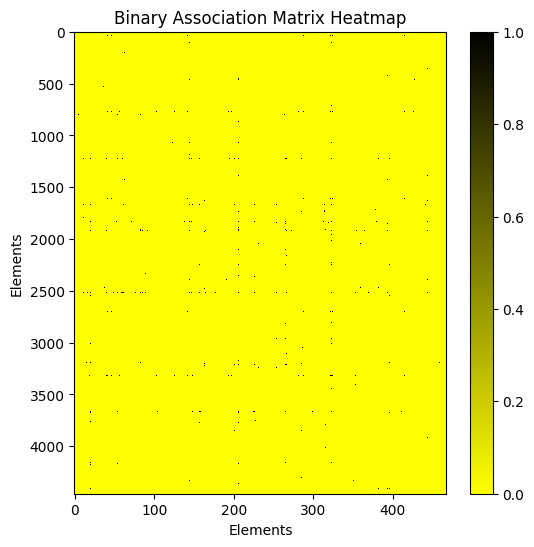

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Example binary association matrix
binary_matrix = lda

# Create a custom colormap where 1's are black and 0's are yellow
colors = [(1, 1, 0), (0, 0, 0)]  # Yellow (1's) and Black (0's)
cmap_name = 'custom_colormap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Plotting the heatmap using the custom colormap
plt.figure(figsize=(6, 6))
plt.title('Binary Association Matrix Heatmap')
plt.imshow(binary_matrix, cmap=custom_cmap, interpolation='nearest', aspect='auto')
plt.xlabel('Elements')
plt.ylabel('Elements')
plt.colorbar()
plt.show()


Finding gaussian kernel profile using the lncRNA disease association matrix

In [ ]:
import numpy as np

def gKernel(nl, nd, inter_lncdis):
    # Compute Gaussian interaction profile kernel of lncRNAs
    sl = np.zeros(nl)
    for i in range(nl):
        sl[i] = np.linalg.norm(inter_lncdis[i, :]) ** 2
    gamal = nl / np.sum(sl) * 1
    pkl = np.zeros((nl, nl))
    for i in range(nl):
        for j in range(nl):
            pkl[i, j] = float(np.exp(-gamal * (np.linalg.norm(inter_lncdis[i, :] - inter_lncdis[j, :])) ** 2))

    # Compute Gaussian interaction profile kernel of diseases
    sd = np.zeros(nd)
    for i in range(nd):
        sd[i] = np.linalg.norm(inter_lncdis[:, i]) ** 2
    gamad = nd / np.sum(sd) * 1
    pkd = np.zeros((nd, nd))
    for i in range(nd):
        for j in range(nd):
            pkd[i, j] = float(np.exp(-gamad * (np.linalg.norm(inter_lncdis[:, i] - inter_lncdis[:, j])) ** 2))

    result_lnc = pkl
    result_dis = pkd

    return result_lnc, result_dis


gip_lnc,gip_dis=gKernel(len(lncRNA_names), len(disease_names), lda)


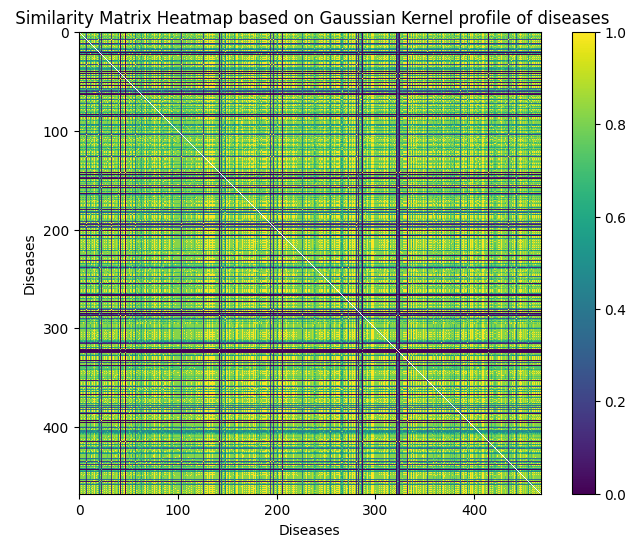

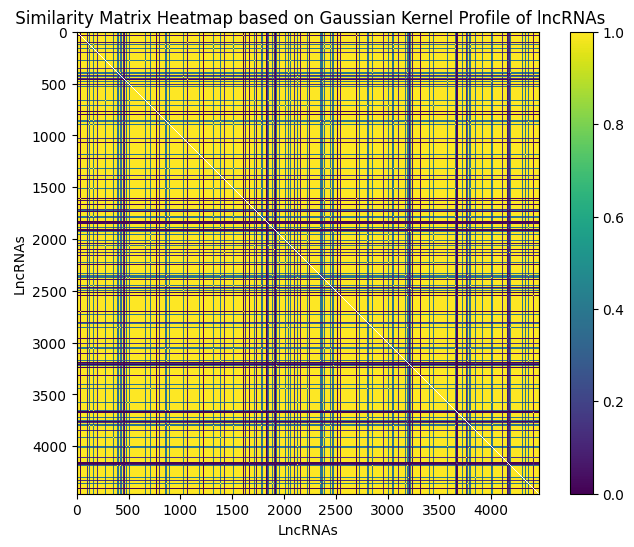

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming similarity_matrix contains your 4458x4458 similarity matrix
# Create a copy of the similarity matrix
similarity_matrix_copy = np.copy(gip_dis)

# Set diagonal elements to NaN
np.fill_diagonal(similarity_matrix_copy, np.nan)

# Normalize the similarity matrix between 0 and 1, ignoring NaN values
scaler = MinMaxScaler()
normalized_similarity_matrix = scaler.fit_transform(similarity_matrix_copy)

plt.figure(figsize=(8, 6))
plt.imshow(normalized_similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(' Similarity Matrix Heatmap based on Gaussian Kernel profile of diseases')
plt.xlabel('Diseases')
plt.ylabel('Diseases')
plt.show()



import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming similarity_matrix contains your 4458x4458 similarity matrix
# Create a copy of the similarity matrix
similarity_matrix_copy = np.copy(gip_lnc)

# Set diagonal elements to NaN
np.fill_diagonal(similarity_matrix_copy, np.nan)

# Normalize the similarity matrix between 0 and 1, ignoring NaN values
scaler = MinMaxScaler()
normalized_similarity_matrix = scaler.fit_transform(similarity_matrix_copy)

plt.figure(figsize=(8, 6))
plt.imshow(normalized_similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(' Similarity Matrix Heatmap based on Gaussian Kernel Profile of lncRNAs')
plt.xlabel('LncRNAs')
plt.ylabel('LncRNAs')
plt.show()
